# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import geopandas as gpd
from pysal.esda.mapclassify import Quantiles
import shapely.geometry as geom
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
import numpy as np

In [2]:
conn = sqlite3.connect("sf_data.sqlite")
c = conn.cursor()

Here I only selected the approved and issued permits, since some of the permits are expired or suspended, and in my opinion should not be included in the calculation, because I tend to only count the locations which are still available now.

In [3]:
c.execute('''select permit.Applicant,count(distinct location.locationid) as count
                  from mobile_food_permits permit
                  join (select distinct locationid, permit from mobile_food_schedule) schedule on permit.permit=schedule.permit
                  join mobile_food_locations location on location.locationid=schedule.locationid
                  where permit.Status in ('APPROVED','ISSUED')
                  group by 1
                  order by -count
                  limit 1
''')
locations=pd.DataFrame(c.fetchall())
locations.columns=['vendor','count']
locations

,vendor,count
0,Park's Catering,23


Through the result we have found that the vendor 'Park's Catering' sells in the most locations which are 23.


__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

Question 1

Do the owner of machine vendors always tend to place their vendors around parkinglot?

I have limited latitude and longitude in most of my sql commands since there are some outliers which do not fall in the area of San Francisco, and their existence will mess up the geo map. I have also limited the status of the permit to approved and issued, and the reason is the same as what I have stated in Problem 1.1.

In [4]:
c.execute('''select location.Latitude,location.Longitude, permit.Applicant,permit.FoodItems
                  from mobile_food_permits permit
                  join (select distinct locationid, permit from mobile_food_schedule) schedule on permit.permit=schedule.permit
                  join mobile_food_locations location on location.locationid=schedule.locationid
                  where permit.Status in ('APPROVED','ISSUED')
                  and location.Latitude >37.65
                  and location.Longitude < -122
''')
vendor=c.fetchall()    
vendor=pd.DataFrame(vendor)
vendor.columns=['Lat','Lon','Applicant','FoodItems']

In [5]:
parking=pd.read_sql_query("select Lat,Lon from parking where lat >37.65 and lon < -122",conn)

In [6]:
def geo(dat):
    '''
    Since we will do a lot of transformation from normal pandas dataframe to geo dataframe,
    I have made a function to dry my code, 
    automatically return the geo dataframe by inputting normal dataframe.
    '''
    lonlat = [geom.Point(lon, lat) for lon, lat in zip(dat.Lon, dat.Lat)]
    dat.drop(["Lon", "Lat"], axis = 1)
    geodat = gpd.GeoDataFrame(dat, geometry = lonlat, crs = {'init' :'epsg:4326'})
    return geodat

Here we eliminate the South San Francisco area with zipcode 94080 since it does not belong to main San Francisco area, and none of the latitude and longitude data fall in this area.

In [7]:
zipcode=pd.read_sql_query("select distinct Regionname from zillow where Regionname!='94080'",conn)

In [15]:
can = gpd.GeoDataFrame.from_file("cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")
can['GEOID10'] = can['GEOID10'].astype(int)
zips=pd.merge(zipcode, can, left_on='RegionName',right_on='GEOID10',how='inner')
zips=gpd.GeoDataFrame(zips)

In [17]:
parkings=geo(parking)
vendors=geo(vendor)

Here we draw a map with boundaries of areas, and mark vendors as stars and parkinglots as circles.

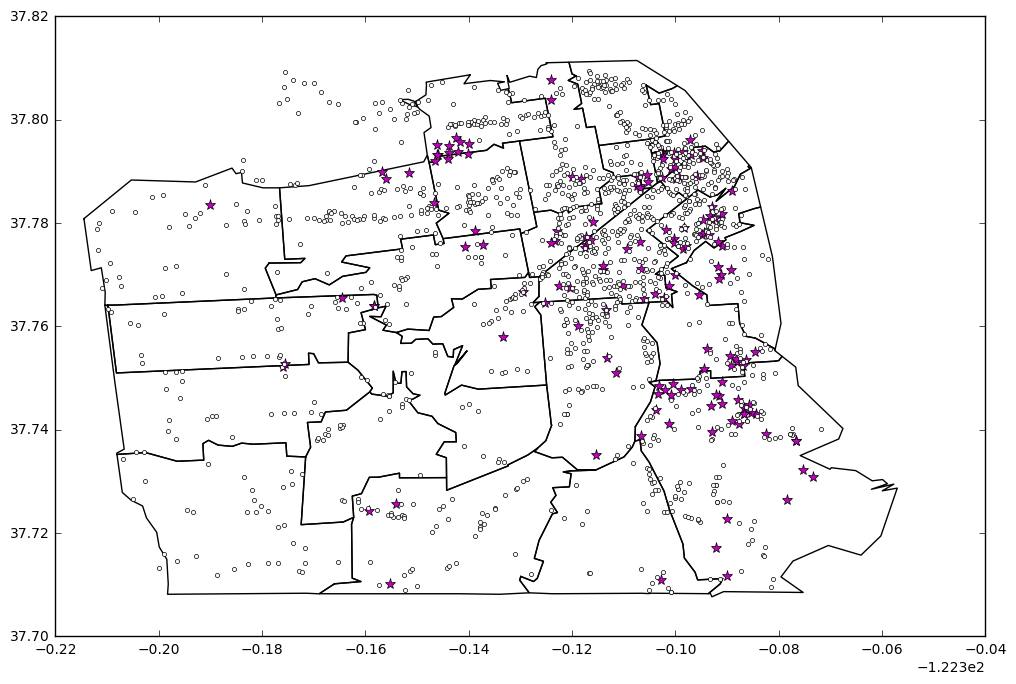

In [18]:
base=zips.plot(color='white')
vendors.plot(ax = base, marker = "*", color = "m",markersize=8)
parkings.plot(ax = base,marker='o', color='white', markersize=3)

Through this plot, we are able to conclude that people do tend to place their vendor machines near the parking lots or parking garages. Through the geographical plot, in which the purple star stands for the vendor machine and the white circles refer to the parking lot, we can observe that for most of the vendors, there are parking lots or parking garage around them. There are exceptions which lie on the mid-top on the plot where a dozen of vendors are placed, and that is probably because there is a huge park or traffic hub. In a word, the owners of vendors tend to place the vendors in the place which has convenient traffic facilities and relatively higher flow of people, and since parking lots always locate around these traffic facilities, we can always find parking lot and garage around the vendors. Also in this way, it is easier for the drivers to drop by and buy stuff from the vendor.


Question 2

What is the relationship between the house price and the size of the parks? Do the areas with higher house price tend to have smaller parks because of the shortness of land supply and expensiveness of land?

In [19]:
park=pd.read_sql_query("select Name,Lat,Lon,Acreage from parks where Lat >37.65 and Lon< -122",conn)
park=park.dropna()

I have tried to make the size of markers of parks dependent on the acres they take. Since some of the parks are tiny and some are huge, I have limited the range of marker size from 4 to 50. The parks smaller than 2 acres will be assigned a marker size of 4, and for every 5 acres increase of park size, the marker size increases by 1, until the sizes reach 50.

In [20]:
m=[]
for i in park.Acreage:
    if i<2:
        m.append(4)
    else:
        n=4+(i-2)/5
        if n>50:
            m.append(50)
        else:
            m.append(n)
park['size']=m

Here I originally want to use the 'partition by order by row number' command to solve the problem like in using oracle sql language, but sqlite does not support this command, so I decide to first extract the zipcodes, house price, and dates from the database, and perform ranking commands through pandas.

In [21]:
price=pd.read_sql_query("select RegionName,MedianSoldPricePerSqft_AllHomes,Date from zillow where MedianSoldPricePerSqft_AllHomes !='None' and Regionname!='94080'",conn)

In [22]:
new=price.assign(rn=price.sort_values(['Date'], ascending=False)\
                 .groupby(['RegionName'])                       \
                 .cumcount() + 1)                               \
                 .query('rn <2')                                \
                 .sort_values(['RegionName','rn']) 

In [23]:
can['GEOID10'] = can['GEOID10'].astype(int)
zips=pd.merge(new, can, left_on='RegionName',right_on='GEOID10',how='inner')
zips=gpd.GeoDataFrame(zips)

Here I have assigned different colors to areas divided by zipcodes according to the newest average house price. The higher the price is, the deeper the redness will be.

/Users/admin/anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


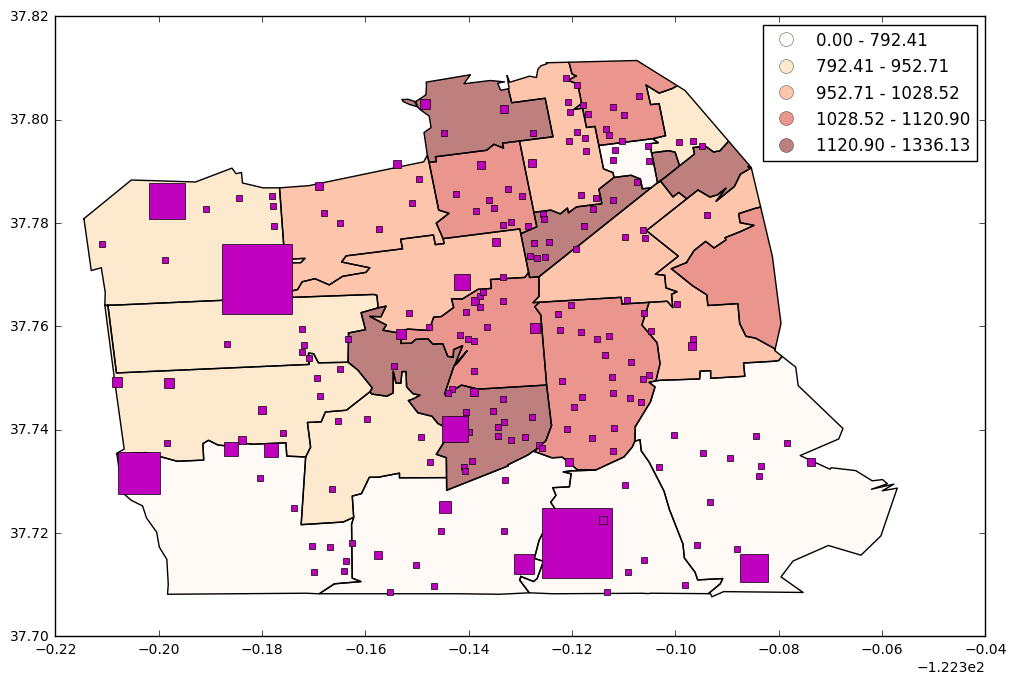

In [24]:
from pysal.esda.mapclassify import Quantiles
base=zips.plot(column='MedianSoldPricePerSqft_AllHomes', scheme='QUANTILES', k=5, colormap='OrRd', legend=True)
for i in range(0,len(park)):
    a=pd.DataFrame(park.iloc[i]).transpose()
    geo(a).plot(ax = base,marker='s', color='m',markersize=a['size'][i])

In the plot, the deeper the redness is, the higher the average price for a square feet in that area. The purple square represents where the parks are, and the size of the square is positively related to the acres occupied by the parks. Through the plot, we can observe that most of the huge parks locate on the area which has a lighter red color, and most of the parks located in the deeper red areas are small. This plot definitely helps to answer our question. Large parks are more likely to locate in the areas with lower house price, and the areas with high house price generally do not have many large parks, possibly due to high price of the land. At the same time, although parks in high price area are small, in the perspective of number of parks, the high price area tends to have more parks than the low price area does, and we can observe this from the plot. In the deeper red area, the intensiveness of distribution of parks is definitely higher.

Question 3

Does the higher house price lead to a quieter place to live?

In [25]:
noise=pd.read_sql_query("select Lat,Lon from noise where Lat >37.65 and Lon< -122",conn)
noises=geo(noise)

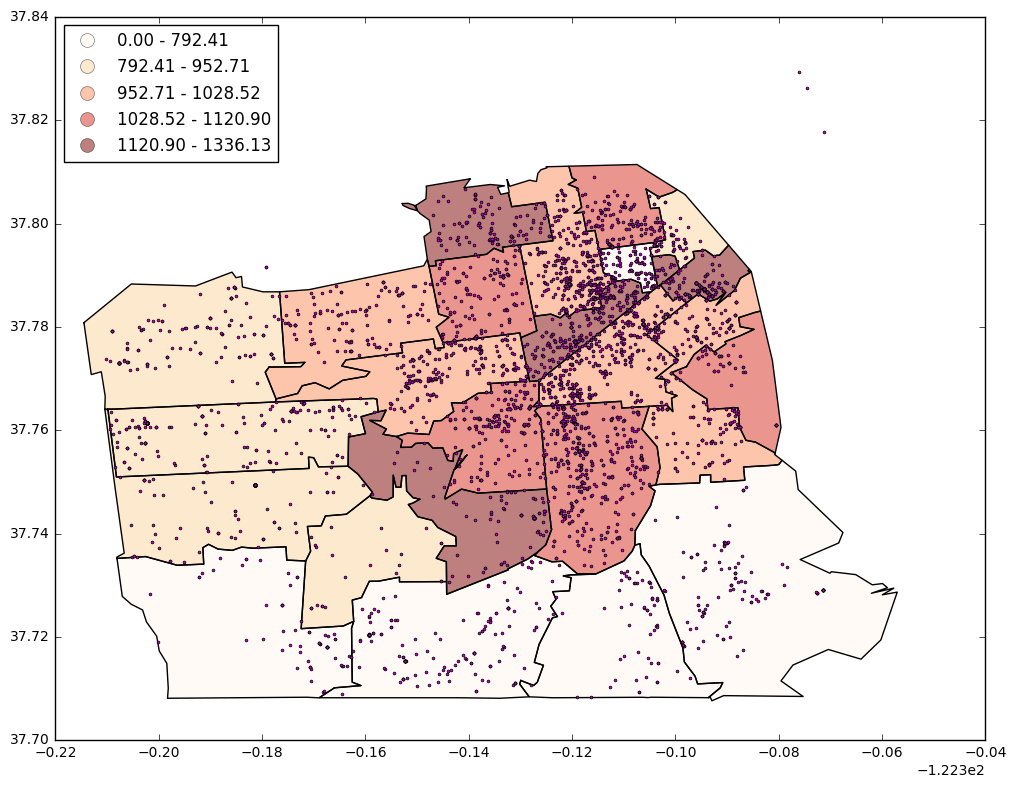

In [26]:
base = zips.plot(column='MedianSoldPricePerSqft_AllHomes', scheme='QUANTILES', k=5, colormap='OrRd', legend=True)
noises.plot(ax = base,marker='o', color='m', markersize=2)

From the plot above, I have found the opposite result to what I have expected. Originally I think a higher house price may lead to a better and quieter place to live, so there will be less noise complaint in the high house price area. However, it turns out that most of the noises complaints take place in the northern, midldle and eastern part of San Francisco, which is the area with the higher price. I have tried to thought deeply on the reason why it behaves that way. In my opinion, the number of noise complaints should be related to the size of flow of people and traffic. The areas which sell for higher price are also the central part of San Francisco, so there is a huge flow of people and traffics everyday, and therefore the risk of creating noises is highly enhanced, causing the intensiveness of the noise in the specific areas. Also, people living in high price areas are more likely to have a higher requirement of living environment, so when they experience the effect of noise, they always choose to complain about it.

Question 4

What are the 5 most common crimes happened in the each hour during a day?

In [27]:
import plotly.plotly as py # interactive graphing
from plotly.graph_objs import Bar, Scatter, Marker, Layout 

In [28]:
crime_traces = {} 

for hours in range(0, 24):
    '''
    Since the hours are denoted in the format '00' to '23', we make some transformation for the integers.
    This loop is designed to form up a dictionary which contains all the information
    on the 5 most common crimes happening through 24 hours of the day
    '''
    hour_str = '0'+str(hours) if hours < 10 else str(hours)
    df = pd.read_sql_query('SELECT  Category ,'
                                   'strftime(\'%H\', Datetime) as `hour`,  '
                                   'COUNT(*) as num_crimes '
                           'FROM crime '
                           'WHERE hour = "{}" '
                           'and category != "OTHER OFFENSES" '
                           'and Lon< -122 '
                           'and Lat >37.65 '
                           'GROUP BY 1 '
                           'ORDER BY -num_crimes'.format(hour_str), conn)
    

    for i in range(5):
        crimetype = df.get_value(i, 'Category')
        count = df.get_value(i, 'num_crimes')
        if crimetype in crime_traces:
            crime_traces[crimetype][hours] = count
        else:
            crime_traces[crimetype] = {hours: count}

traces = []
for crimetype in crime_traces:
    traces.append({
        'x': range(25),
        'y': [crime_traces[crimetype].get(i, None) for i in range(25)],
        'name': crimetype,
        'type': 'bar'
    })

py.iplot({
    'data': traces, 
    'layout': {
        'barmode': 'stack',
        'xaxis': {'title': 'Hour in Day'},
        'yaxis': {'title': 'Number of Crimes'},
        'title': 'The 5 Most Common Crimes Happened by Hour in a Day'
    }}, filename='most common crimes by hour')

The plot is pretty informative on describing the top 5 types of crimes happen the most in 24 hours. We can observe that for different time periods, the types of crime which is more likely to happen are different. Among all the types of crime, Non-criminal, Laeceny/Theft, and Assault are always in the top 5 types of crimes through a day. After 5pm, vandalisms are more likely to happen, because it is easier for the criminals to destroy stuff and run away at night without sunlight. Also, we can observe that the criminal warrants are always executed during daytime, maybe because there are more police on call during the day. Drug crime appear more often during 1pm to 5pm, and robbery always happen around midnight. At last, we can also see that the crimes are more likely to happen after noon from 12pm to midnight, which is completely understandable.

Question 5

Do the vendors generally sell different food for lunch and dinner?

For this problem, we need to make two thing clear first. The first issue is how to define breakfast and lunch. I consider vendors which sell through 8am as breakfast, and vendors which sell through noon as lunch. The second issue is that the schedule table includes the time assigned in all weekdays, and I have picked Monday as the representative of the whole week, since Monday is a typical weekday in which workers and students need to have their breakfast and lunch. 

In [29]:
c.execute('''select  FoodItems,Endhour,Starthour
                  from mobile_food_permits permit
                  join mobile_food_schedule schedule on permit.permit=schedule.permit
                  where permit.Status in ('APPROVED','ISSUED')
                  and starthour<=12
                  and endhour>=12
                  and DayOfWeek='Mo'
''')
lunch=pd.DataFrame(c.fetchall())
lunch.columns=['food','End','start']

In [30]:
c.execute('''select  FoodItems,Endhour,Starthour
                  from mobile_food_permits permit
                  join mobile_food_schedule schedule on permit.permit=schedule.permit
                  where permit.Status in ('APPROVED','ISSUED')
                  and starthour<=8
                  and endhour>=8
                  and DayOfWeek='Mo'
''')
breakfast=pd.DataFrame(c.fetchall())
breakfast.columns=['food','End','start']

In [31]:
import string as str
from itertools import chain

In [32]:
def transform(data):
    '''
    in order to plot the wordcloud for the food sold by the vendors,
    I need to do some pre-processing with the data by first split the foods in the food items,
    and then transform into a string contained all the names of the food.
    '''
    food=data.food.str.split(pat='[^\w\s] ')
    food=[i.encode('ascii','ignore') for i in list(chain.from_iterable(food))]
    food = [x.replace(' ', '') for x in food]
    food=' '.join(food)
    return food

In [33]:
lunchfood=transform(lunch)
breakfastfood=transform(breakfast)

In [38]:
from wordcloud import WordCloud
def wcloud(lem):
    '''
    Since I have plotted several wordclouds, I have defined a function to return the wordcloud and dry my code.
    '''
    return WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      background_color="white",
                      max_words=1000,
                      max_font_size=40, random_state=42
                      ).generate(lem)

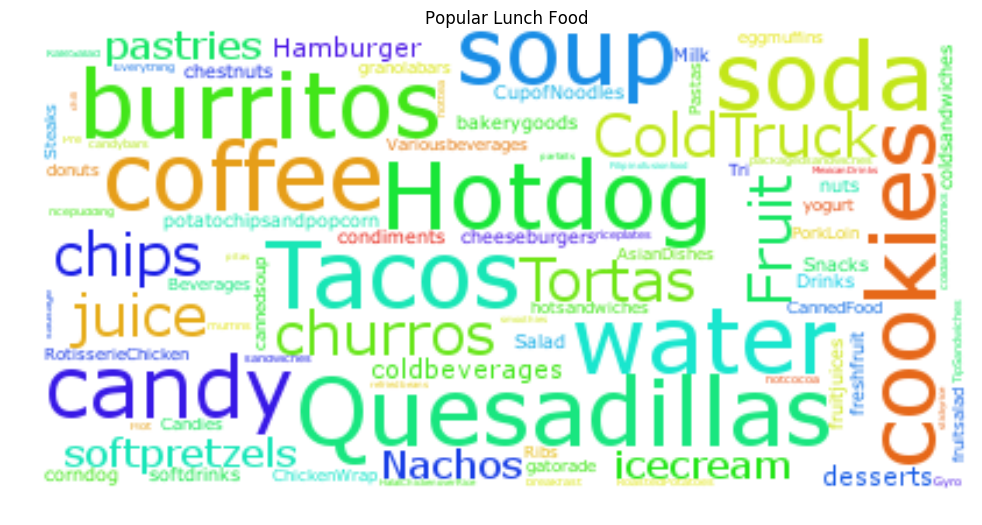

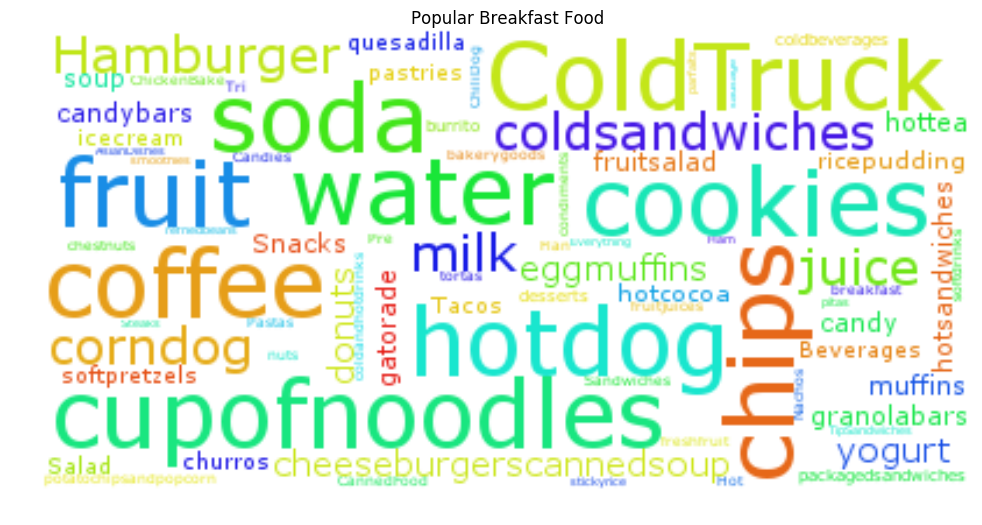

In [39]:
plt.figure(1)
plt.imshow(wcloud(lunchfood))
plt.axis("off")
plt.title("Popular Lunch Food")
plt.show()

plt.figure(2)
plt.imshow(wcloud(breakfastfood))
plt.axis("off")
plt.title("Popular Breakfast Food")
plt.show()

Through these 2 wordclouds, we can observe that there are both similarities and differences between the food generally sold for Breakfast and lunch. Some foods are sold by mobile vendors for both lunch and breakfast. From the wordcloud, we can observe that hotdogs, soda, water, cookies, and coffee appeared in both plots, meaning that people tend to have them both for lunch and breakfast. The differences between the preferred food in lunch and breakfast are also apparent. For the lunch, the sellers tend to sell Quesadillas, Tacos, burritos, soup, and Tortas. For the breakfast, coldsandwiches, cup of noodles, and milk are the popular choices for both sellers and buyers. From this data, we can see that people have different appetite for lunch and breakfast, and the mobile vendor owners have worked to accomodate different demands made by the customers.